In [1]:
import glob
import os
import cv2
import glob
import pylab as pl
import seaborn as sns
import numpy as np

In [7]:
%matplotlib notebook

In [3]:
# from scipy import misc,interpolate,stats,signal
def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


def process_maps(mapdata, smooth_fwhm=None, mag_thr=None, recenter=True, mask_mag=True):
    phase_az = mapdata['phaseMap'].copy()
    mag_az = mapdata['magRatioMap'].copy()
    
    # phase_az[mag_az<mag_thr]=np.nan

    if smooth_fwhm is not None:
        phase_az =smooth_array(phase_az, smooth_fwhm, phaseArray=True)
        mag_az = smooth_array(mag_az, smooth_fwhm)

    if recenter:
        phaseC_az = shift_map(phase_az)
        phasemin = 0
        phasemax = 2*np.pi
    else:
        phaseC_az = np.copy(phase_az)
        phasemin = -np.pi
        phasemax = np.pi

    phaseC_az[mag_az<mag_thr]=np.nan
    
    magC_az = mag_az.copy()
    if mask_mag:
        magC_az[mag_az<mag_thr]=np.nan
    
    return phaseC_az, magC_az, phasemin, phasemax

def shift_map(phase_az):
    phaseC_az=np.copy(phase_az)
    if phase_az[~np.isnan(phase_az)].min() < 0 and phase_az[~np.isnan(phase_az)].max() > 0:
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
    else:
        print("Already non-negative (min/max: %.2f, %.2f)" % (phase_az.min(), phase_az.max()))
    return phaseC_az


In [8]:
# surface_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'

rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Widefield:
analysis_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_subdirs = 'Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean'


In [9]:
animalid = 'JC085' #'JC113' #'JC076'

# find sessions
found_sessions = np.unique([os.path.split(sesh)[-1].split('_')[0] \
                  for sesh in glob.glob(os.path.join(analysis_basedir, animalid, '2019*'))])
print('[%s]: Found %i sessions' % (animalid, len(found_sessions)))
for si, sesh in enumerate(found_sessions):
    print(si, sesh)
    

sesh = found_sessions[-1]
print(sesh)
surface_path = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % sesh, 'Surface', '*.png'))[0]
session = os.path.split(surface_path.split('/Surface')[0])[-1].split('_')[0]
data_id = '%s_%s' % (animalid, session)
print("DATA ID: %s" % data_id)

[JC085]: Found 2 sessions
0 20190619
1 20190620
20190620
DATA ID: JC085_20190620


Surface image (492, 656 | uint16)


<IPython.core.display.Javascript object>


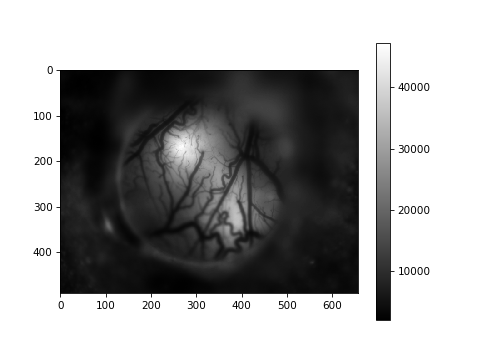

In [11]:
animalid ='JC085'
surface_path = glob.glob(os.path.join(rootdir, animalid, 'macro_maps', '20*', '*urf*.png'))[0]

# surface_path = glob.glob(os.path.join(surface_basedir, animalid, '2019*_high*', 'Surface', '*.png'))[0]
# surface_hd = cv2.imread(surface_path, -1)
# print(surface_hd.shape)

# surface_path = glob.glob(os.path.join(surface_basedir, animalid, '%s' % session, 'Surface', '*.png'))[0]
# surface = cv2.imread(surface_path, -1)
# print(surface.shape)

surface = cv2.imread(surface_path, -1)
widefield_d1, widefield_d2 = surface.shape
print("Surface image (%i, %i | %s)" % (widefield_d1, widefield_d2, surface.dtype))
surface = cv2.imread(surface_path, -1)
widefield_d1, widefield_d2 = surface.shape

fig, ax = pl.subplots()
im = ax.imshow(surface, cmap='gray', interpolation='nearest')
pl.colorbar(im)

In [ ]:
screen_x = 119.5564
screen_y = 67.323
resolution = [1920, 1080] #[1024, 768]


In [32]:
import dill as pkl

In [35]:
# retmap_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper'
# fn = os.path.join(retmap_dir, 'JC085_20190620/20200601/20190620_MJC085_loadresults.pkl')

# with open(fn, 'rb') as f:
#     rmap = pkl.load(f)
    

In [38]:
# Load colormap
from matplotlib.colors import LinearSegmentedColormap

colormap = 'nic_Edge'
cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])


In [ ]:
outdir = os.path.join(aggregate_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir